In [2]:
%ls ../data

Business_Licenses.csv  README.md


In [166]:
from datetime import datetime 
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib2tikz

%matplotlib inline

In [25]:
data_dir = Path("../data/")
df = pd.read_csv(data_dir/"Business_Licenses.csv", low_memory=False)

In [33]:
dt_cols = [
    'LICENSE TERM START DATE', 
    'LICENSE TERM EXPIRATION DATE',
    'DATE ISSUED']
df[dt_cols] = df[dt_cols].apply(pd.to_datetime).apply(lambda _:_.dt.year)

df


,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION
0,22308-20060816,1723393,29481,1,BELL OIL TERMINAL INC,Bell Oil Terminal LLC,3741 S PULASKI RD 1,CHICAGO,IL,60623,...,2006.0,2007.0,08/10/2006,2006,AAI,NaN,NaN,41.825320,-87.723960,"(41.82531992987547, -87.72395999659746)"
1,1620668-20160516,2455262,295026,1,BUCCI BIG & TALL INC.,BUCCI BIG & TALL INC.,558 W ROOSEVELT RD,CHICAGO,IL,60607,...,2016.0,2018.0,05/18/2016,2016,AAI,NaN,NaN,41.867339,-87.641590,"(41.86733856638269, -87.64159005699716)"
2,2368602-20160616,2460909,291461,3,"PROJECT: VISION , INC.","PROJECT : VISION , INC",2301 S ARCHER AVE 1 1,CHICAGO,IL,60616,...,2016.0,2017.0,06/21/2016,2016,AAC,08/30/2016,NaN,41.850843,-87.638734,"(41.85084294374687, -87.63873424399071)"
3,2060891-20141016,2353257,357247,1,FOLASHADE'S CLEANING SERVICE INC.,FOLASHADE'S CLEANING SERVICE INC.,1965 BERNICE RD 1 1SW,LANSING,IL,60438,...,2014.0,2016.0,04/01/2016,2016,AAI,NaN,38.0,41.951316,-87.678586,"(41.95131555606832, -87.67858578019546)"
4,1144216-20070516,1804790,147,63,WALGREEN CO.,Walgreens # 05192,9148 S COMMERCIAL AVE 1ST,CHICAGO,IL,60617,...,2007.0,2008.0,05/10/2007,2007,AAI,NaN,5.0,41.728622,-87.551366,"(41.72862173556932, -87.55136646594693)"
5,2488345-20160830,2488345,409564,1,"BURKS HEATING AND COOLING SOLUTIONS, LLC","BURKS HEATING AND COOLING SOLUTIONS, LLC",5722 S WOOD ST 1ST,CHICAGO,IL,60636,...,2016.0,2018.0,08/30/2016,2016,AAI,NaN,NaN,41.789617,-87.669472,"(41.78961679000226, -87.66947199630827)"
6,22308-20030816,1479006,29481,1,BELL OIL TERMINAL INC,Bell Oil Terminal LLC,3741 S PULASKI RD 1,CHICAGO,IL,60623,...,2003.0,2004.0,03/25/2004,2004,AAI,NaN,NaN,41.825320,-87.723960,"(41.82531992987547, -87.72395999659746)"
7,2354707-20160916,2482568,393149,1,ANGELINE R. MC CARTHY,ANGELINE R. MC CARTHY,17707 S HARLEM ST 1,TINLEY PARK,IL,60477,...,2016.0,2018.0,NaN,2016,AAI,NaN,NaN,NaN,NaN,NaN
8,22308-20010816,1151715,29481,1,BELL OIL TERMINAL INC,Bell Oil Terminal LLC,3741 S PULASKI RD 1,CHICAGO,IL,60623,...,2001.0,2002.0,08/10/2001,2004,AAI,NaN,NaN,41.825320,-87.723960,"(41.82531992987547, -87.72395999659746)"
9,1144216-20030516,1338337,147,63,WALGREEN CO.,Walgreens # 05192,9148 S COMMERCIAL AVE 1ST,CHICAGO,IL,60617,...,2003.0,2004.0,04/28/2003,2003,AAI,NaN,5.0,41.728622,-87.551366,"(41.72862173556932, -87.55136646594693)"


In [34]:
df.drop(
    columns=['ID', 'LATITUDE', 'LONGITUDE', 'POLICE DISTRICT', 'WARD PRECINCT', 'APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE'], 
    inplace=True)

In [85]:
renewals = df[
    (df["APPLICATION TYPE"] == "RENEW") & # subsequent renewal
    (df["LICENSE STATUS"]   == "AAI")     # license granted
]

latest_renewal_experation_year = (
    renewals.groupby(["LICENSE NUMBER"])["LICENSE TERM EXPIRATION DATE"]
    .apply(max)
    .to_frame())

latest_failures = latest_renewal_experation_year[latest_renewal_experation_year["LICENSE TERM EXPIRATION DATE"] <= 2018]

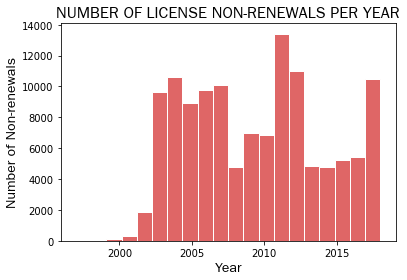

In [184]:
font = lambda s: {'fontname':'ITC Franklin Gothic Std', 'size': s}

latest_failures.plot(kind="hist", facecolor="#df6666", edgecolor="white", bins=20)
plt.title("Number of License Non-renewals Per Year".upper(), **font(16))
plt.xlabel("Year", **font(14))
plt.ylabel("Number of Non-renewals", **font(14))
plt.gca().get_legend().remove()

plt.savefig("non-renewals-over-time.svg", bbox_inches='tight', dpi=300)
# matplotlib2tikz.save("non-renewals-over-time.tex", figureheight="3in", figurewidth="3in")
plt.show()

In [102]:
business_failures = latest_failures.join(df, rsuffix="_orig", how="left")
(100 * business_failures["BUSINESS ACTIVITY"].value_counts(normalize=True)).to_frame().head(10)

,BUSINESS ACTIVITY
Operation of a Fuel Filling Station,23.497835
Retail Sales of Perishable Foods,12.311688
Buying and Reselling of Used Valuable Objects,10.476190
Consumption of Liquor on Premises,3.991342
Sales of Packaged Frozen Desserts From a Non-Motorized Cart (Mobile Desserts Vendor),2.744589
Tavern - Consumption of Liquor on Premise,1.878788
Hair Services,1.670996
Preparation of Food and Dining on Premise With Seating,1.627706
Other Home Occupations,1.619048
Miscellaneous Commercial Services,1.428571


In [154]:
wards = gpd.read_file("wards/wards.shp") 

failures_by_ward = business_failures["WARD"].value_counts()

# couldn't get indexes to work :(
wards["num_failures"] = wards["ward"].map(lambda w: failures_by_ward.get(int(w), 0))

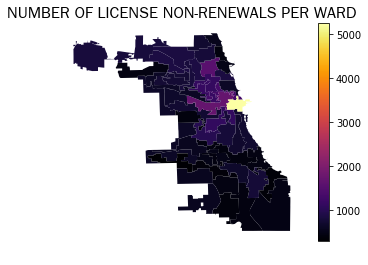

In [186]:
wards.plot(column="num_failures", legend=True, cmap='inferno')
plt.gca().axis("off")
plt.title("Number of License Non-renewals Per Ward".upper(), **font(16))
plt.savefig("failure-choropleth.png", bbox_inches="tight", dpi=300)
